In [1]:
import os
from gwas_analysis.dask import get_dask_client
from gwas_analysis.dask.io import BedArray
from pysnptools.snpreader import Bed
from gwas_analysis.method import pruning
import dask.array as da
import os.path as osp
import numpy as np
import pandas as pd
import hail as hl
%run {os.environ['NB_DIR']}/nb.py
%run $BENCHMARK_METHOD_DIR/common.py

### Initialize

In [2]:
plink_path = HAPMAP_PLINK_FILE
ds_path = ld_prune_tild.dataset_path(DATASET_HM)
ds_pos_path = ds_path + '-pos.csv'
ds_calls_path = ds_path + '-calls.zarr'
ds_path_out_plink = ds_path + '-plink-prune'
plink_path, ds_path, ds_pos_path, ds_calls_path, ds_path_out_plink

('/home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_1',
 '/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap',
 '/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap-pos.csv',
 '/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap-calls.zarr',
 '/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap-plink-prune')

## Dataset Prep

In [9]:
hail_init()

Running on Apache Spark version 2.4.4
SparkUI available at http://015d228af3f1:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.32-a5876a0a2853
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/benchmark/method/ld_prune/tild/hail-20200303-1933-0.2.32-a5876a0a2853.log


In [10]:
mt = hl.import_plink(
    *plink_files(osp.dirname(HAPMAP_PLINK_FILE), osp.basename(HAPMAP_PLINK_FILE)),
    reference_genome='hapmap3_hg18'
)
# Remove small contigs (especially 25 for HapMap)
mt = mt.filter_rows(hl.set(['1']).contains(mt.locus.contig))
# Remove rows with no variance
mt = mt.annotate_rows(stdev=hl.agg.stats(mt.GT.n_alt_alleles()).stdev)
mt = mt.filter_rows(mt.stdev > 0)
pd.Series(mt.aggregate_rows(hl.agg.counter(mt.locus.contig))).sort_index()

2020-03-03 19:33:16 Hail: INFO: Found 165 samples in fam file.
2020-03-03 19:33:16 Hail: INFO: Found 1457897 variants in bim file.
2020-03-03 19:33:25 Hail: INFO: Coerced sorted dataset
2020-03-03 19:33:25 Hail: INFO: reading 1 of 2 data partitions


1    103646
dtype: int64

In [11]:
# Export the filtered dataset to PLINK (for zarr conversion)
def export_plink(mt, path):
    hl.export_plink(
        mt, path, 
        fam_id=mt.fam_id,
        pat_id=mt.pat_id,
        mat_id=mt.mat_id,
        is_female=mt.is_female,
        pheno=mt.is_case,
        varid=mt.rsid
    )
    return path
export_plink(mt, ds_path)

2020-03-03 19:33:39 Hail: INFO: Coerced sorted dataset
2020-03-03 19:33:39 Hail: INFO: reading 1 of 2 data partitions
2020-03-03 19:33:44 Hail: INFO: Coerced sorted dataset
2020-03-03 19:33:44 Hail: INFO: reading 1 of 2 data partitions
2020-03-03 19:33:49 Hail: INFO: Coerced sorted dataset
2020-03-03 19:33:49 Hail: INFO: reading 1 of 2 data partitions
2020-03-03 19:33:55 Hail: INFO: Coerced sorted dataset
2020-03-03 19:33:55 Hail: INFO: reading 1 of 2 data partitions
2020-03-03 19:34:00 Hail: INFO: Coerced sorted dataset
2020-03-03 19:34:00 Hail: INFO: reading 1 of 2 data partitions
2020-03-03 19:34:10 Hail: INFO: merging 2 files totalling 4.2M...
2020-03-03 19:34:10 Hail: INFO: while writing:
    /home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap.bed
  merge time: 32.237ms
2020-03-03 19:34:10 Hail: INFO: merging 1 files totalling 2.9M...
2020-03-03 19:34:10 Hail: INFO: while writing:
    /home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap.bim
  merge time: 19.04

'/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap'

In [12]:
# Export contig/loci csv
def export_positions(mt, path):
    ht = mt.key_rows_by().rows()
    ht = ht.select(contig=ht.locus.contig, pos=ht.locus.position)
    ht.export(path)
    return path
export_positions(mt, ds_pos_path)
!head $ds_pos_path

2020-03-03 19:34:15 Hail: INFO: Coerced sorted dataset
2020-03-03 19:34:15 Hail: INFO: reading 1 of 2 data partitions
2020-03-03 19:34:24 Hail: INFO: merging 1 files totalling 1.1M...
2020-03-03 19:34:24 Hail: INFO: while writing:
    /home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap-pos.csv
  merge time: 10.478ms


contig	pos
1	557616
1	742584
1	744045
1	750775
1	758311
1	766409
1	769185
1	828418
1	836671


In [13]:
def export_calls(input_path, output_path):
    gt = da.from_array(BedArray(Bed(input_path, count_A1=True)), chunks=(100000, 165), lock=False)
    # Convert 0=missing, 1=homo ref, etc to -1=missing, 0=homo ref
    gt = gt.astype(np.int8) - 1
    gt.to_zarr(output_path, overwrite=True)
    return gt
X = export_calls(ds_path, ds_calls_path)
X

dask.array<sub, shape=(103646, 165), dtype=int8, chunksize=(100000, 165), chunktype=numpy.ndarray>

In [14]:
X.min().compute(), X.max().compute()

(-1, 2)

In [15]:
!du -ch $ds_path*

6.5M	/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap-calls.zarr
4.0K	/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap-plink-prune.log
736K	/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap-plink-prune.prune.in
5.3M	/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap-plink-prune.prune.out
1.2M	/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap-pos.csv
4.2M	/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap.bed
3.0M	/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap.bim
8.0K	/home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap.fam
21M	total


## Execution

In [4]:
window, step = 5000, 500

### PLINK

In [5]:
def run_plink(window, step, threshold, stdout=True):
    if stdout:
        !plink --bfile $ds_path --indep-pairwise $window $step $threshold --out $ds_path_out_plink
    else:
        !plink --bfile $ds_path --indep-pairwise $window $step $threshold --out $ds_path_out_plink > /dev/null
tr = %timeit -o -r 1 -n 1 run_plink(window, step, .8, stdout=True)
tr.best

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap-plink-prune.log.
Options in effect:
  --bfile /home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap
  --indep-pairwise 5000 500 0.8
  --out /home/eczech/data/gwas/benchmark/datasets/ld_prune/tild/hapmap-plink-prune

128535 MB RAM detected; reserving 64267 MB for main workspace.
103646 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Tota

5.05949957401026

### Dask

In [6]:
client = get_dask_client(n_workers=6, processes=True, n_threads=1)
client

Client Scheduler: tcp://127.0.0.1:45245 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 120.00 GB


In [7]:
pos = pd.read_csv(ds_pos_path, sep='\t')
# Check that all contig indices are increasing
assert np.all(pos['contig'].diff().dropna() >= 0)
# Check that all loci are increasing within each contig
assert np.all(pos.groupby('contig').apply(lambda g: g['pos'].diff().min()) > 0)
pos.head()

,contig,pos
0,1,557616
1,1,742584
2,1,744045
3,1,750775
4,1,758311


In [8]:
pos.groupby('contig').size()

contig
1    103646
dtype: int64

In [9]:
X = da.from_zarr(ds_calls_path)
X

dask.array<from-zarr, shape=(103646, 165), dtype=int8, chunksize=(100000, 165), chunktype=numpy.ndarray>

In [10]:
def run_dask(window, step, threshold, numba, short_circuit):
    R, info = pruning.prune(
        X, pos.values, 
        window=window, step=step,
        threshold=threshold,
        windows_per_chunk=3,
        numba=numba,
        short_circuit=short_circuit,
        compute=True
    )
    return R, info

# To check chunks: info[0].chunks

tr = %timeit -o -r 1 -n 1 run_dask(window, step, .8, True, True)
tr.best

17.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


17.309895651997067

## Comparison

In [11]:
df = []
for t in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
    print('Running pruning for R2 threshold', t)
    for params in [[True, False], [True, True]]: #, [False, False]]:
        numba, short_circuit = params
        tr = %timeit -o -r 3 -n 1 run_dask(window, step, t, numba, short_circuit)
        for timing in tr.timings:
            df.append(dict(calc='dask', time=timing, threshold=t, numba=numba, short_circuit=short_circuit))
    tr = %timeit -o -r 1 -n 1 run_plink(window, step, t, stdout=False)
    df.append(dict(calc='plink', time=tr.best, threshold=t))
    
df = pd.DataFrame(df)

Running pruning for R2 threshold 0.1
15.6 s ± 1.67 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
12.2 s ± 1.51 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
893 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Running pruning for R2 threshold 0.2
25.8 s ± 3 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
20 s ± 2.2 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.53 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Running pruning for R2 threshold 0.3
24.2 s ± 1.96 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
21.5 s ± 190 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Running pruning for R2 threshold 0.4
33.4 s ± 4.82 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
35.7 s ± 4.61 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
2.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Running pruning for R2 threshold 0.5
41.6 s ± 873 ms per loop (mean

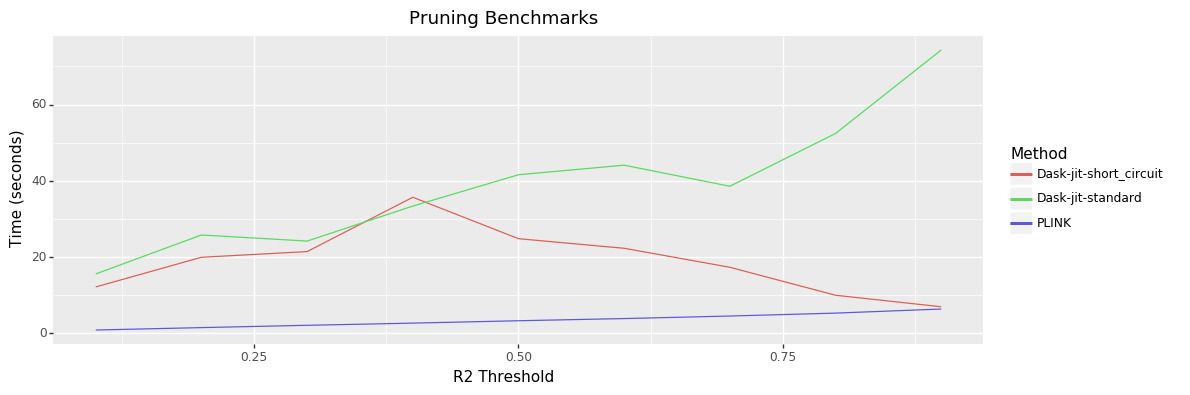

<ggplot: (8733966322865)>

In [20]:
import plotnine as pn
def get_method(r):
    if r['calc'] == 'plink':
        return 'PLINK'
    assert r['calc'] == 'dask'
    return 'Dask-{}-{}'.format(
        'jit' if r['numba'] else 'nojit', 
        'short_circuit' if r['short_circuit'] else 'standard'
    )

(
    pn.ggplot(
        df
            .assign(method=lambda df: df.apply(get_method, axis=1))
            .groupby(['threshold', 'method'])['time'].mean().rename('time').reset_index(), 
        pn.aes(x='threshold', y='time', color='method')
    ) + 
    pn.geom_line() + 
    pn.labs(title='Pruning Benchmarks', y='Time (seconds)', x='R2 Threshold', color='Method') + 
    pn.theme(figure_size=(12, 4))
)

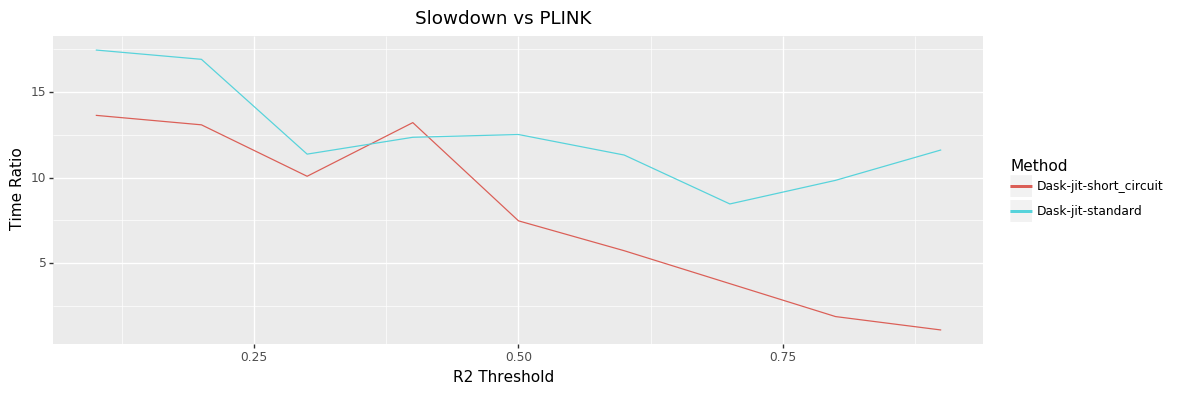

<ggplot: (8733977989137)>

In [46]:
(
    pn.ggplot(
    df
        .assign(method=lambda df: df.apply(get_method, axis=1))
        .pipe(lambda df: (
            df[df['calc'] != 'plink'].pivot_table(index='threshold', columns='method', values='time') /
            df[df['calc'] == 'plink'].pivot_table(index='threshold', columns='method', values='time').values
        ))
        .stack().rename('slowdown').reset_index(),
        pn.aes(x='threshold', y='slowdown', color='method')
    ) + 
    pn.geom_line() +
    pn.labs(title='Slowdown vs PLINK', color='Method', x='R2 Threshold', y='Time Ratio') +
    pn.theme(figure_size=(12, 4))
)